In [1]:
from Data_interpret.GroundTruth import ReadMat
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import sys

In [2]:
# Loading DATA
train_file = "../Raw_data/8_8_2019 to 8_12_2019/2019-08-08-19-16-02_5sec.mat"
train_file2 = "../Raw_data/8_8_2019 to 8_12_2019/2019-08-09-13-01-42_10sec.mat"
train_data = ReadMat(train_file)
train_data2 = ReadMat(train_file2)
# train_data = ReadMat(train_file2)
test_file = "../Raw_data/8_8_2019 to 8_12_2019/2019-08-09-12-49-56_7sec.mat"
test_data = ReadMat(test_file)

# SAMPLING DATA
sample_size = 100  # sampling of raw data
train_state_traj, train_action_traj = train_data.sampled_mocap_data(sample_size)  # state X time, number of actions X time
train_state_traj2, train_action_traj2 = train_data2.sampled_mocap_data(sample_size)  # state X time, number of actions X time
test_state_traj, test_action_traj = test_data.sampled_mocap_data(sample_size)

In [3]:
def DMD(X,Xprime,r):
    ''' This function computes the linear approximation to a nonlinear dynamical system whose state 
    recordings are passed in.
    
    Arguments:
    
    Input:
    
        X: The states of the system
        
        Xprime: the rate of change of the states obtained form finite differencing or direct measurement
        
        r: the rank of the low-rank approximation
        
    Output:
    
        Phi: State transition matrix
        
        Lambda: Eigenvalues of Atilde
        
        b: Amplitude of the modes
    '''
    # obtain singular value decompositon matrices truncated to order r
    U,Sigma,VT = np.linalg.svd(X,full_matrices=0) # Step 1
    Ur = U[:,:r]
    Sigmar = np.diag(Sigma[:r])
    VTr = VT[:r,:]
    
    # Obtain the reduced order system matrix,i.e, A matrix 
    Atilde = np.linalg.solve(Sigmar.T,(Ur.T @ Xprime @ VTr.T).T).T # Step 2
    
    # Obtain the eiegnvales and eigenvectors of the system matrix
    Lambda, W = np.linalg.eig(Atilde) # Step 3
    Lambda = np.diag(Lambda)
    
    # obtain the state transition matrix for the discrete time linear approximation and also 'b' which helps 
    # reconstruct time dynamics
    Phi = Xprime @ np.linalg.solve(Sigmar.T,VTr).T @ W # Step 4
    alpha1 = Sigmar @ VTr[:,0]
    b = np.linalg.solve(W @ Lambda,alpha1)
    
    return Phi, Lambda, b, Atilde

In [4]:
def DMDc(X,Xprime,Upsilon,r,B = np.zeros((1,1))):
    ''' This function computes the linear approximation to a controlled nonlinear dynamical system whose state 
    recordings and control inputs are passed in.
    
    Arguments:
    
    Input:
    
        X: The states of the system
        
        Xprime: the rate of change of the states obtained form finite differencing or direct measurement
        
        Upsilon: The control action data
        
        B: The matrix that dicstates how the control actions affect the system, if available
        
        r: the rank of the low-rank approximation
        
    Output:
    
        Phi: State transition matrix
        
        Lambda: Eigenvalues of Atilde
        
        b: Amplitude of the modes
    '''
    # if B is unkown
    if((B == np.zeros((1,1))).all()):
        # obtain Omega matrix
        Omega = np.vstack([X,Upsilon])
        # Do an SVD on Omega
        Util,Stil,VTtil = np.linalg.svd(Omega,full_matrices=0)
        Vtil = VTtil.T
        #Do an SVD no Xprime
        Uhat,Shat,VThat = np.linalg.svd(Xprime,full_matrices = 0)
        Vhat = VThat.T
        # obtain dimensions of state space and control action 
        n = X.shape[0] # state space dimension
        q = Upsilon.shape[0] # control action dimension
        # obtain U matrices corresponding to A and B
        U_1 = Util[0:n,:]
        U_2 = Util[n:,:]
        # find A and B
        A = Uhat.T@Xprime@Vtil@np.linalg.inv(np.diag(Stil))@U_1.T@Uhat
        B = Uhat.T@Xprime@Vtil@np.linalg.inv(np.diag(Stil))@U_2.T
        
        return A,B
        
    # if B is known
    else : 
        Xprime = Xprime-B@Upsilon
        return DMD(X,Xprime,r)

## Given 
$$x_{k+1} = f(x_k,u_k)$$ 
## or 
$$x_{k+1} = f(x_k) + g(x_k)u$$ 
## We need to find 
$$x_{k+1} = Ax_k+Bu_k$$

$x = \begin{bmatrix} 
\dot{x} \\
\dot{y} \\
\dot{z} \\
\theta_x \\
\theta_y \\
\theta_z \\
\omega_x \\
\omega_y \\
\omega_z \\
\end{bmatrix}$
&emsp;  &emsp; &emsp; 
$\dot{x} = \begin{bmatrix} 
\ddot{x} \\
\ddot{y} \\
\ddot{z} \\
\dot{\theta}_x \\
\dot{\theta}_y \\
\dot{\theta}_z \\
\dot{\omega}_x \\
\dot{\omega}_y \\
\dot{\omega}_z \\
\end{bmatrix}$
&emsp;  &emsp; &emsp;
$A_{9 \times 9} = ?$
&emsp;  &emsp; &emsp;
$B_{9 \times 3} = \begin{bmatrix}
0 & 0 & 0\\
0 & 0 & 0\\
1 & 0 & 0\\
0 & 0 & 0\\
0 & 0 & 0\\
0 & 0 & 0\\
0 & 1 & 0\\
0 & 0 & 1\\
0 & 0 & 0\\
\end{bmatrix}$
&emsp;  &emsp; &emsp;
$u = \begin{bmatrix}
u_{zaccel} \\
u_{roll} \\
u_{pitch}
\end{bmatrix}
$



## Assuming B is known

In [5]:
X = train_state_traj2[:,0:-1]
Xprime = train_state_traj2[:,1:]

Upsilon = train_action_traj2[:,0:-1] 

Omega = np.vstack([X,Upsilon])

# define the B matrix
B_sys = np.zeros((9,3))
B_sys[2,0]  = 1
B_sys[6,1] = 1
B_sys[7,2] = 1

r = 9 # number of states
dt = 0.01 # in seconds

In [6]:
Phi, Lambda, b, A = DMDc(X,Xprime,Upsilon,r, B_sys)
omega = np.log(np.diag(Lambda))/dt

In [7]:
# reconstruct dynamics with DMD as a sanity check
start_time = 0
end_time = X.shape[1]*dt
time = np.arange(start_time,end_time,dt) # time vector

time_dynamics = np.zeros([Phi.shape[1],len(time)])

for i in range(time_dynamics.shape[1]):
    time_dynamics[:,i] = b*np.exp(omega*time[i])
    
X_dmd = np.dot(Phi,time_dynamics)

print(time)

[0.000e+00 1.000e-02 2.000e-02 ... 1.052e+01 1.053e+01 1.054e+01]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in exp
  if __name__ == '__main__':


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


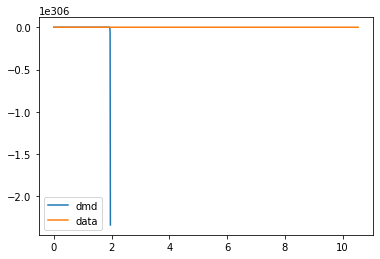

In [8]:
plt.plot(time,X_dmd[2,:],label='dmd')
plt.plot(time,X[2,:],label='data')
plt.legend()

In [9]:
x = test_state_traj
u = test_action_traj

In [10]:
xdot.shape

NameError: name 'xdot' is not defined

In [11]:
x0 = x[:,0]
xdot = A@x[:,0]+B_sys@u[:,0]
xdot= xdot.reshape((-1,1))
new= xdot
for i in range(1,u.shape[1]):
    #print(new.shape)
    input_val= u[:,i].reshape((-1,1))
    new= A @ new + B_sys @ input_val
    #print(new.shape)
    xdot = np.hstack((new,xdot))
    #print(xdot.shape)
    

print(xdot)
    

[[            nan             nan             nan ... -1.29757173e+03
  -4.72878671e+01 -5.15626782e+00]
 [            nan             nan             nan ... -5.84708792e+00
   8.42200013e-01 -3.54144926e-01]
 [            nan             nan             nan ... -3.54223145e+02
  -3.85783792e+01 -1.12898728e+01]
 ...
 [            nan             nan             nan ... -4.21703268e+03
  -1.13040611e+02 -2.80147357e+00]
 [            nan             nan             nan ...  7.58250312e+03
   2.02495782e+02  4.90350550e+00]
 [            nan             nan             nan ...  1.94885165e+03
   5.20179675e+01  1.29570426e+00]]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in matmul
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in matmul
  


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\ticker.py:2039: RuntimeWarning: overflow encountered in multiply
  steps = self._extended_steps * scale


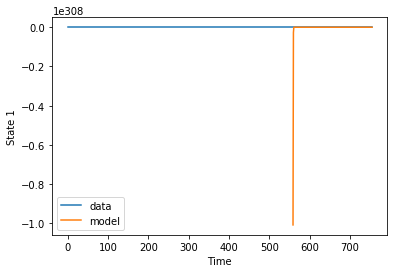

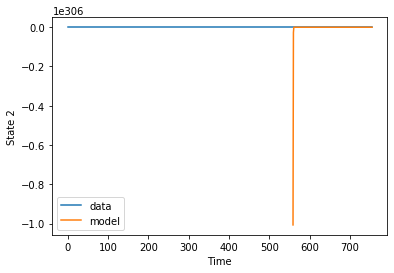

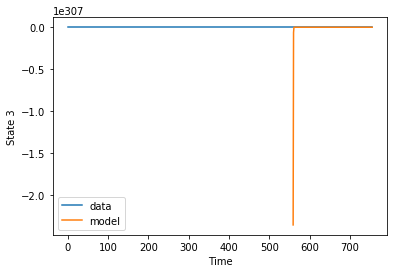

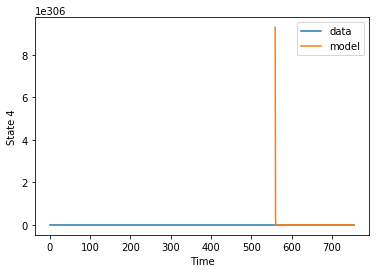

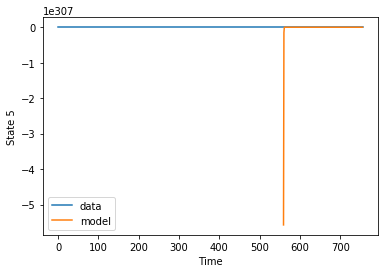

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\ticker.py:2039: RuntimeWarning: overflow encountered in multiply
  steps = self._extended_steps * scale
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\ticker.py:2072: RuntimeWarning: overflow encountered in multiply
  ticks = np.arange(low, high + 1) * step + best_vmin


OverflowError: cannot convert float infinity to integer

<Figure size 432x288 with 1 Axes>

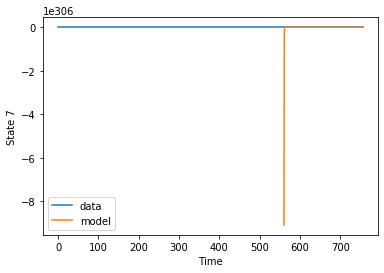

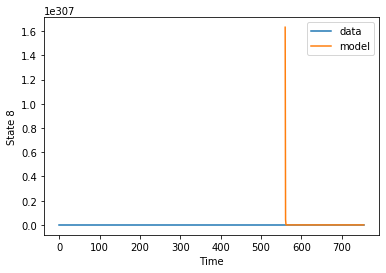

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\ticker.py:2039: RuntimeWarning: overflow encountered in multiply
  steps = self._extended_steps * scale
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\ticker.py:2071: RuntimeWarning: overflow encountered in double_scalars
  high = edge.ge(_vmax - best_vmin)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\ticker.py:1879: RuntimeWarning: invalid value encountered in double_scalars
  d, m = divmod(x, self.step)


ValueError: arange: cannot compute length

In [12]:
for i in range(9):
    plt.plot(test_state_traj[i,:],label ='data')
    plt.plot(xdot[i,:],label = 'model')
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('State '+str(i+1))
    plt.show()

In [ ]:
eig_val,eig_vec = np.linalg.eig(A)

In [13]:
eig_val

NameError: name 'eig_val' is not defined

## Assuming B is unknown

In [14]:
X = train_state_traj2[:,0:-1] # data
Xprime = train_state_traj2[:,1:] # data derivative

Upsilon = train_action_traj2[:,0:-1] 

Omega = np.vstack([X,Upsilon])

r = 9 # number of states
dt = 0.01 # in seconds

In [15]:
A,B = DMDc(X,Xprime,Upsilon,r)

In [16]:
ind = np.where(np.abs(B) > 1e-02)
B

array([[-2.26475655e-02,  8.61282010e-02,  1.29928471e-02],
       [ 8.09388519e-03, -1.67970626e-02,  2.85451209e-02],
       [-1.59732579e-02,  2.94312028e-02, -7.97855876e-02],
       [ 2.13314610e-03, -7.11289802e-05,  1.83787242e-02],
       [ 1.05089804e-03, -1.77149662e-03,  3.76683916e-03],
       [ 1.39788901e-04, -5.01205147e-04, -2.96717550e-03],
       [ 9.99598257e-06,  8.42793428e-06, -4.48843600e-04],
       [ 1.05951324e-04, -3.21593083e-04, -6.13477425e-04],
       [ 2.65899398e-04, -4.59405831e-05,  3.22289561e-03]])

In [18]:
x0 = x[:,0]
xdot = A@x[:,0]+B@u[:,0]
xdot= xdot.reshape((-1,1))
new= xdot
for i in range(1,u.shape[1]):
    input_val= u[:,i].reshape((-1,1))
    new= A @ new + B @ input_val
    xdot = np.hstack((new,xdot))
    
xdot=xdot.T
print(xdot.shape)

(756, 9)


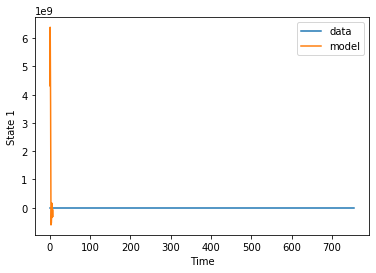

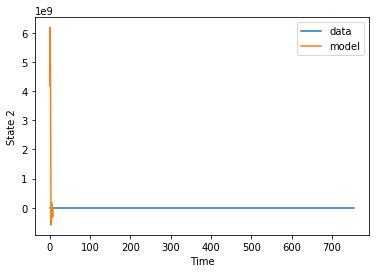

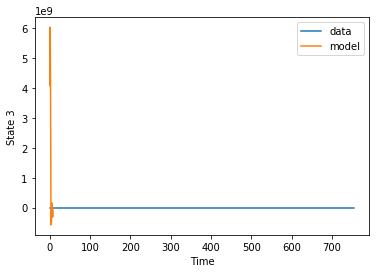

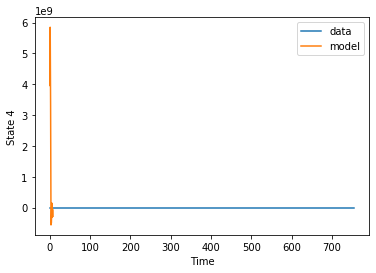

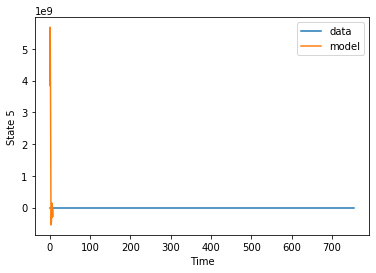

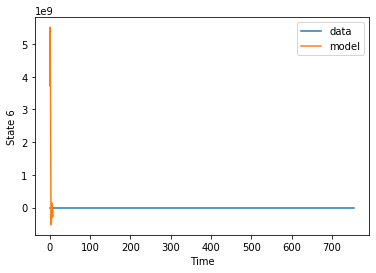

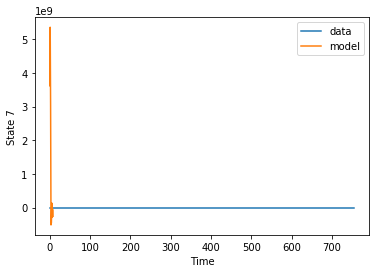

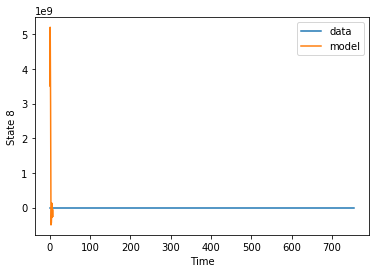

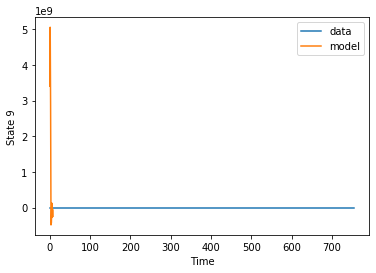

In [19]:
for i in range(9):
    plt.plot(test_state_traj[i,:],label ='data')
    plt.plot(xdot[i,:],label = 'model')
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('State '+str(i+1))
    plt.show()
    